# Analysis

Select modalities, events, parameters 

In [173]:
# List with optional commented-out modalities
modalities = [
    'NoseVector.x',        
    #'NoseVector.y',          
    'EyeDirWorldCombined.x', 
    #'EyeDirWorldCombined.y',  
    #'EyeDirLocalCombined.x',        
    #'EyeDirLocalCombined.y',        
    #'SteeringInput',         
]


# --- Toggle events by commenting them out ---
event_filter_list = [   
    #'NoEvent', # UNCOMMENT THIS TO INCLUDE ALL EVENTS
    #'StagEventNew',        
    'FallingRocksEventNew',
    'FogEventNew',         
    #'I_variant',           
    #'III_variant',
    #'MarketPlaceEvent',
    #'CyclistEvent',       
    # 'Panne',                  
    # 'GhostDriver',
    # 'Baustelle',          
    #'MotorcyclistEvent'    ,
]


#for the raw data plotting 
#condition_filter = 'BaseCondition'
#condition_filter = '!BaseCondition'
#condition_filter = 'HUDOnly'
#condition_filter = 'AudioOnly'
#condition_filter = 'FullLoopAR'
condition_filter = 'All Conditions'



points_per_window = 500  # 10 seconds @ 50Hz
global_sigma = 0.000001    # smoothing strength



In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from sklearn.decomposition import PCA
import gc
import glob  
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pathos.pools
from functools import partial
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from scipy.ndimage import gaussian_filter1d


c:\Users\erene\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52849 instead
  warnings.warn(
c:\Users\erene\AppData\Local\Programs\Python\Python310\lib\contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (6.22s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Define and load dataframe

In [175]:
# Define dtypes to load all uid files
dtypes = {'uid': 'str','dataset': 'str','city_section': 'str','ExperimentalCondition': 'str','EventName': 'object','HitObjectName': 'object','ObjectName_4': 'object','ObjectName_5': 'object', 'EventDuration': 'float64', 'TimeStamp': 'float64'}
# Define the path to the CSV file
dir = os.getcwd()
data_path = dir + '/Data/'

# Load all data
ddf = dd.read_csv(data_path + '*.csv', assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)

# Load DataFrame  
df = dd.read_csv(data_path + "cleaned_windowed.csv", assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)  
event_windows_df = df.compute() 

# Convert to pandas for processing
df = df.compute()  #  convert to full pandas DataFrame

print("DataFrame shape before event filtering:", df.shape)

# --- Filter the windows if any of these events occur in the window ---
grouped = event_windows_df.groupby(['uid', 'WindowNumber'])
windows_event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

print("DataFrame shape before condition filtering:", windows_event_filtered.shape)

# Filter conditions
df = windows_event_filtered
if condition_filter != 'All Conditions':
    if condition_filter == '!BaseCondition':
        windows_event_condition_filtered = df[df['ExperimentalCondition'] != 'BaseCondition']
        condition_filter = "Any warning (non-control)"
    else:
        windows_event_condition_filtered = df[df['ExperimentalCondition'] == condition_filter]
else:
    windows_event_condition_filtered = df

print("DataFrame shape after filtering:", windows_event_condition_filtered.shape)

# Check structure  
if 'WindowNumber' not in df.columns or 'uid' not in df.columns:
    raise ValueError("❌ 'WindowNumber' and/or 'uid' column missing in event_windows_df")




DataFrame shape before event filtering: (873000, 90)
DataFrame shape before condition filtering: (160000, 90)
DataFrame shape after filtering: (160000, 90)


Plot raw data for each modality

In [176]:
# # Centering and standardizing data for each observation (participant's data per modality)
# raw_all_participant_curves = []

# for (uid, win), sub_df in windows_event_condition_filtered.groupby(['uid', 'WindowNumber']):
#     if len(sub_df) != points_per_window:
#         continue  # Skip incomplete windows

#     if not all(col in sub_df.columns for col in modalities):
#         continue

#     data = sub_df[modalities].copy()
    
#     raw_all_participant_curves.append(data.T)

# if len(raw_all_participant_curves) == 0:
#     raise ValueError("❌ No valid participant data found!")

# # Stack to 3D array: (N_windows, T, M)
# raw_data_array = np.stack(raw_all_participant_curves, axis=0)  # shape: (W, M, T)
# raw_data_array = np.transpose(raw_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

# W, T, M = raw_data_array.shape
# print(f"Loaded {W} valid windows, shape = ({W}, {T}, {M})")
# time_sec = np.linspace(-5, 5, T)# Loop through each modality (M) and plot the data for each participant
# for m in range(M):
#     # Extract modality-specific data
#     raw_modality_data = raw_data_array[:, :, m]  # Shape: (W, T)
    
#     # Debug: Check the shape of the modality data
#     print(f"Modality {m} data shape: {raw_modality_data.shape}")

#     # Create a new figure for each modality
#     plt.figure(figsize=(10, 6))

#     # Plot the raw time series for each participant
#     for participant_data in raw_modality_data:
#         plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data

#     # Compute and plot the mean time series across participants
#     raw_mean_data = raw_modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
    
#     # Debug: Check the mean data
#     print(f"Mean data for modality {m}: {raw_mean_data[:5]}")  # Print first few values of mean data
    
#     # Get the modality name from the modalities list
#     modality_name = modalities[m]  # Assuming modalities is a list of names
    
#     plt.plot(time_sec, raw_mean_data, label=f"Mean {modality_name}", color='blue', linewidth=2)  # Mean line

#     plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
#     plt.xlabel("Time (s)")
#     plt.ylabel(f"Modality {modality_name} Values")
#     plt.title(f"Raw Time Series for {modality_name}, {event_filter_list} , {condition_filter}")
    
#     # Set y-axis limits
#     plt.ylim(-1, 1)

#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


Center and standardize

In [177]:
# Centering and standardizing data for each observation (participant's data per modality)
all_participant_curves = []

for (uid, win), sub_df in windows_event_condition_filtered.groupby(['uid', 'WindowNumber']):
    if len(sub_df) != points_per_window:
        continue  # Skip incomplete windows

    if not all(col in sub_df.columns for col in modalities):
        continue

    data = sub_df[modalities].copy()

    # Center each participant's data (curve) on its own mean
    for modality_idx in range(data.shape[1]):
        modality_data = data.iloc[:, modality_idx].values  # Extract modality data for current participant
        modality_data_centered = modality_data - modality_data.mean()  # Center the data
        data.iloc[:, modality_idx] = modality_data_centered  # Replace the modality with centered data
    
    # Standardize each modality's data across all participants
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    all_participant_curves.append(data_scaled.T)

if len(all_participant_curves) == 0:
    raise ValueError("❌ No valid participant data found!")

# Stack to 3D array: (N_windows, T, M)
Pca_data_array = np.stack(all_participant_curves, axis=0)  # shape: (W, M, T)
Pca_data_array = np.transpose(Pca_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

W, T, M = Pca_data_array.shape
print(f"Loaded {W} valid windows, shape = ({W}, {T}, {M})")
time_sec = np.linspace(-5, 5, T)

Loaded 320 valid windows, shape = (320, 500, 2)


Plot centered and standardized variables

In [178]:
# # Loop through each modality (M) and plot the data for each participant
# for m in range(M):
#     # Extract modality-specific data
#     modality_data = Pca_data_array[:, :, m]  # Shape: (W, T)
    
#     # Debug: Check the shape of the modality data
#     print(f"Modality {m} data shape: {modality_data.shape}")

#     # Create a new figure for each modality
#     plt.figure(figsize=(10, 6))

#     # Plot the raw time series for each participant
#     for participant_data in modality_data:
#         plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data

#     # Compute and plot the mean time series across participants
#     mean_data = modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
    
#     # Debug: Check the mean data
#     print(f"Mean data for modality {m}: {mean_data[:5]}")  # Print first few values of mean data
    
#     # Get the modality name from the modalities list
#     modality_name = modalities[m]  # Assuming modalities is a list of names
    
#     plt.plot(time_sec, mean_data, label=f"Mean {modality_name}", color='blue', linewidth=2)  # Mean line

#     plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
#     plt.xlabel("Time (s)")
#     plt.ylabel(f"Modality {modality_name} Values")
#     plt.title(f"Standardized Time Series for {modality_name}, {event_filter_list} , {condition_filter}")
    
#     # Set y-axis limits
#     plt.ylim(-3, 3)

#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


# Time-wise PCA ED Curve

In [179]:
# # --- Compute cov matrix ---
# cov_matrix = np.zeros((T, M, M))

# # Compute covariance matrix for each time step
# for t in range(T):
#     snapshot = data_array[:, t, :]  # shape: (W, M)
#     centered = snapshot - snapshot.mean(axis=0)
#     cov_matrix[t] = np.dot(centered.T, centered) / (W - 1)
# # --- Compute ED Over Time (Quadratic Entropy) ---
# ed_curve = []

# for t in range(T):
#     eigvals = eigh(cov_matrix[t], eigvals_only=True)
#     eigvals = np.clip(eigvals, 1e-12, None)
#     p = eigvals / np.sum(eigvals)
#     ED = 1 / np.sum(p**2)    
#     ed_curve.append(ED)

# # --- Smooth the ED Curve ---
# smoothed_ed = gaussian_filter1d(ed_curve, sigma=global_sigma)

# # --- Plot ED Curve ---
# seconds = np.linspace(0, 10, T)

# plt.figure(figsize=(10, 6))
# plt.plot(seconds, ed_curve, color='lightgray', linewidth=1, label='Original ED', alpha=0.5)
# plt.plot(seconds, smoothed_ed, color='blue', linewidth=2, label='Smoothed ED (σ= {global_sigma})')
# plt.axvline(5, color='gray', linestyle='--', label='Event Onset (0s)')
# plt.xlabel("Time (s)")
# plt.ylabel("Effective Dimensionality")
# plt.title(f"Time-wise ED Curve of {modalities}, {condition_filter}, {event_filter_list}")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# # --- Compute PCA based Global Scalar ED ---
# # Extract eigenvalues from covariance matrix at time 0 (or any time slice)
# Cov_matrix_eigenvalues = eigh(cov_matrix[0], eigvals_only=True)  # Eigenvalues at time 0
# Cov_matrix_eigenvalues = np.clip(Cov_matrix_eigenvalues, 1e-12, None)  # Avoid very small eigenvalues
# p = Cov_matrix_eigenvalues / np.sum(Cov_matrix_eigenvalues)  # Normalize eigenvalues
# ED_global = 1 / np.sum(p**2)  # Effective dimensionality (Scalar)

# # --- Report ---
# print(f"PCA based global scalar ED: {ED_global:.2f} using {len(Cov_matrix_eigenvalues)} components")


In [180]:
# local_sigma = 5
# global_sigma = local_sigma     # smoothing strength

# # Set whether to plot all events together or separately
# plot_separately = True  # Change this to True if you want to plot each event separately

# # --- Define condition filters ---
# condition_filters = [
#     'BaseCondition', 
#     #'!BaseCondition',
#     'HUDOnly', 
#     'AudioOnly', 
#     'FullLoopAR', 
#     #'All Conditions'
# ]


# # List of colors for each condition
# colors = {
#     'BaseCondition': 'pink',
#     '!BaseCondition': 'black',
#     'HUDOnly': 'red',
#     'AudioOnly': 'blue',
#     'FullLoopAR': 'green',
#     'All Conditions': 'purple'  
# }

# # --- OPTIONAL: Data Loading, Filtering, and Preparation ---


# # Load the DataFrame  
# df = dd.read_csv(data_path + "cleaned_windowed.csv", assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)  
# event_windows_df = df.compute() 

# # Convert to pandas for processing
# df = df.compute()  # Convert to full pandas DataFrame

# print("DataFrame shape before event filtering:", df.shape)

# # --- Filter the windows if any of these events occur in the window ---
# grouped = event_windows_df.groupby(['uid', 'WindowNumber'])
# windows_event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

# print("DataFrame shape before condition filtering:", windows_event_filtered.shape)


# # --- Apply condition filters ---
# df = windows_event_filtered
# non_base_conditions = ['HUDOnly', 'AudioOnly', 'FullLoopAR']  # Define non-base conditions

# # Start plotting to avoid overwriting
# plt.figure(figsize=(14, 8))

# for condition_filter in condition_filters:
#     condition_label = condition_filter  # Set the label to the condition_filter for use in the plot

#     if condition_filter == 'All Conditions':
#         windows_event_condition_filtered = df
#     elif condition_filter == 'BaseCondition':
#         windows_event_condition_filtered = df[df['ExperimentalCondition'] == 'BaseCondition']
#     elif condition_filter == '!BaseCondition':
#         # Combine all non-base conditions
#         windows_event_condition_filtered = df[df['ExperimentalCondition'].isin(non_base_conditions)]
#         condition_label = "Non-Base Conditions"  # Label it as "Non-Base Conditions"
#     else:
#         windows_event_condition_filtered = df[df['ExperimentalCondition'] == condition_filter]

#     print(f"DataFrame shape for {condition_label}:", windows_event_condition_filtered.shape)

#     # --- Check structure ---
#     if 'WindowNumber' not in df.columns or 'uid' not in df.columns:
#         raise ValueError("❌ 'WindowNumber' and/or 'uid' column missing in event_windows_df")

#     all_participant_curves = []

#     for (uid, win), sub_df in windows_event_condition_filtered.groupby(['uid', 'WindowNumber']):
#         if len(sub_df) != points_per_window:
#             continue  # Skip incomplete windows

#         if not all(col in sub_df.columns for col in modalities):
#             continue

#         data = sub_df[modalities].copy()
#         scaler = StandardScaler()
#         data_scaled = scaler.fit_transform(data)
#         all_participant_curves.append(data_scaled.T)

#     if len(all_participant_curves) == 0:
#         print(f"❌ No valid participant data found for condition '{condition_label}'")
#         continue  # Skip to next condition

#     # Stack to 3D array: (N_windows, T, M)
#     data_array = np.stack(all_participant_curves, axis=0)  # shape: (W, M, T)
#     data_array = np.transpose(data_array, (0, 2, 1))  # Convert to shape (W, T, M)

#     W, T, M = data_array.shape
#     print(f"Loaded {W} valid windows for condition '{condition_label}', shape = ({W}, {T}, {M})")

#     # --- Compute covariance matrix ---
#     cov_matrix = np.zeros((T, M, M))

#     # Compute covariance matrix for each time step
#     for t in range(T):
#         snapshot = data_array[:, t, :]  # shape: (W, M)
#         centered = snapshot - snapshot.mean(axis=0)
#         cov_matrix[t] = np.dot(centered.T, centered) / (W - 1)

#     # --- Compute ED Over Time (Quadratic Entropy) ---
#     ed_curve = []
#     for t in range(T):
#         eigvals = eigh(cov_matrix[t], eigvals_only=True)
#         eigvals = np.clip(eigvals, 1e-12, None)
#         p = eigvals / np.sum(eigvals)
#         ED = 1 / np.sum(p**2)    
#         ed_curve.append(ED)

#     # --- Smooth the ED Curve ---
#     smoothed_ed = gaussian_filter1d(ed_curve, sigma=global_sigma)

#     # --- Plot ED Curve for each condition, overlaid ---
#     seconds = np.linspace(0, 10, T)
#     plt.plot(seconds, smoothed_ed, label=f'{condition_label} ED', linewidth=2, color=colors.get(condition_label, 'black'))

# # --- Add plot details ---
# plt.axvline(5, color='gray', linestyle='--', label='Event Onset (0s)')
# plt.xlabel("Time (s)")
# plt.ylabel("Effective Dimensionality")
# plt.title(f"Time-wise ED Curve of {modalities} for All Conditions")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # --- Compute Global Scalar ED ---
# # Extract eigenvalues from covariance matrix at time 0 (or any time slice)
# Cov_matrix_eigenvalues = eigh(cov_matrix[0], eigvals_only=True)  # Eigenvalues at time 0
# Cov_matrix_eigenvalues = np.clip(Cov_matrix_eigenvalues, 1e-12, None)  # Avoid very small eigenvalues
# p = Cov_matrix_eigenvalues / np.sum(Cov_matrix_eigenvalues)  # Normalize eigenvalues
# ED_global = 1 / np.sum(p**2)  # Effective dimensionality (Scalar)

# # --- Report ---
# print(f"PCA based global scalar ED: {ED_global:.2f} using {len(Cov_matrix_eigenvalues)} components")


In [181]:
# local_sigma = 1     # smoothing strength

# # Set whether to plot all events together or separately
# plot_separately = True  # Change this to True if you want to plot each event separately

# # --- Define condition filters ---
# local_condition_filters = [
#     'BaseCondition', 
#     '!BaseCondition',
#     #'HUDOnly', 
#     #'AudioOnly', 
#     #'FullLoopAR', 
#     #'All Conditions'
# ]


# # List of colors for each condition
# colors = {
#     'BaseCondition': 'pink',
#     '!BaseCondition': 'black',
#     'HUDOnly': 'red',
#     'AudioOnly': 'blue',
#     'FullLoopAR': 'green',
#     'All Conditions': 'purple'  
# }

# # --- OPTIONAL: Data Loading, Filtering, and Preparation ---


# # Load the DataFrame  
# dflocal = dd.read_csv(data_path + "cleaned_windowed.csv", assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)  
# event_windows_df = dflocal.compute() 

# # # Convert to pandas for processing
# # dflocal = dflocal.compute()  # Convert to full pandas DataFrame

# print("DataFrame shape before event filtering:", df.shape)

# # --- Filter the windows if any of these events occur in the window ---
# grouped = event_windows_df.groupby(['uid', 'WindowNumber'])
# windows_event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

# print("DataFrame shape before condition filtering:", windows_event_filtered.shape)


# # --- Apply condition filters ---
# df = windows_event_filtered
# non_base_conditions = ['HUDOnly', 'AudioOnly', 'FullLoopAR']  # Define non-base conditions

# # Start plotting to avoid overwriting
# plt.figure(figsize=(14, 8))

# for local_condition_filter in local_condition_filters:
#     condition_label = local_condition_filter  # Set the label to the condition_filter for use in the plot

#     if local_condition_filter == 'All Conditions':
#         windows_event_condition_filtered = df
#     elif local_condition_filter == 'BaseCondition':
#         windows_event_condition_filtered = df[df['ExperimentalCondition'] == 'BaseCondition']
#     elif local_condition_filter == '!BaseCondition':
#         # Combine all non-base conditions
#         windows_event_condition_filtered = df[df['ExperimentalCondition'].isin(non_base_conditions)]
#         condition_label = "Non-Base Conditions"  # Label it as "Non-Base Conditions"
#     else:
#         windows_event_condition_filtered = df[df['ExperimentalCondition'] == local_condition_filter]

#     print(f"DataFrame shape for {condition_label}:", windows_event_condition_filtered.shape)

#     # --- Check structure ---
#     if 'WindowNumber' not in df.columns or 'uid' not in df.columns:
#         raise ValueError("❌ 'WindowNumber' and/or 'uid' column missing in event_windows_df")

#     all_participant_curves = []

#     for (uid, win), sub_df in windows_event_condition_filtered.groupby(['uid', 'WindowNumber']):
#         if len(sub_df) != points_per_window:
#             continue  # Skip incomplete windows

#         if not all(col in sub_df.columns for col in modalities):
#             continue

#         data = sub_df[modalities].copy()

#         # Center each participant's data (curve) on its own mean
#         for modality_idx in range(data.shape[1]):
#             modality_data = data.iloc[:, modality_idx].values  # Extract modality data for current participant
#             modality_data_centered = modality_data - modality_data.mean()  # Center the data
#             data.iloc[:, modality_idx] = modality_data_centered  # Replace the modality with centered data

#         # Standardize each modality's data across all participants
#         scaler = StandardScaler()
#         data_scaled = scaler.fit_transform(data)
        
#         # Plot the newly transformed (centered and standardized) data for each modality
#         time_sec = np.linspace(-5, 5, T)  # Time vector (make sure T is defined)
#         for m in range(data_scaled.shape[1]):  # Iterate over modalities
#             plt.figure(figsize=(10, 6))
#             modality_data = data_scaled[:, m]  # Get the modality data for plotting
#             # Plot each participant's transformed data (before PCA)
#             for participant_data in modality_data:
#                 plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data
#             # Plot the mean transformed data across participants
#             mean_data = modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
#             plt.plot(time_sec, mean_data, label=f"Mean {modalities[m]}", color='blue', linewidth=2)  # Mean line

#             plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
#             plt.xlabel("Time (s)")
#             plt.ylabel(f"Transformed {modalities[m]} Values")
#             plt.title(f"Transformed Time Series for {modalities[m]} (Centered & Standardized)")
#             plt.legend()
#             plt.grid(True)
#             plt.tight_layout()
#             plt.show()
        
#         all_participant_curves.append(data_scaled.T)

#     if len(all_participant_curves) == 0:
#         raise ValueError("❌ No valid participant data found!")

#     # Stack to 3D array: (N_windows, T, M)
#     t_data_array = np.stack(all_participant_curves, axis=0)  # shape: (W, M, T)
#     t_data_array = np.transpose(t_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

#     W, T, M = t_data_array.shape
#     print(f"Loaded {W} valid windows, shape = ({W}, {T}, {M})")



#     # --- Compute covariance matrix ---
#     cov_matrix = np.zeros((T, M, M))

#     # Compute covariance matrix for each time step
#     for t in range(T):
#         snapshot = t_data_array[:, t, :]  # shape: (W, M)
#         centered = snapshot - snapshot.mean(axis=0)
#         cov_matrix[t] = np.dot(centered.T, centered) / (W - 1)

#     # --- Compute ED Over Time (Quadratic Entropy) ---
#     ed_curve = []
#     for t in range(T):
#         eigvals = eigh(cov_matrix[t], eigvals_only=True)
#         eigvals = np.clip(eigvals, 1e-12, None)
#         p = eigvals / np.sum(eigvals)
#         ED = 1 / np.sum(p**2)    
#         ed_curve.append(ED)

#     # --- Smooth the ED Curve ---
#     smoothed_ed = gaussian_filter1d(ed_curve, sigma=local_sigma)

#     # --- Plot ED Curve for each condition, overlaid ---
#     seconds = np.linspace(-5, 5, T)
#     plt.plot(seconds, smoothed_ed, label=f'{condition_label} ED', linewidth=2, color=colors.get(condition_label, 'black'))

# # --- Add plot details ---
# plt.axvline(0, color='gray', linestyle='--', label='Event Onset (0s)')
# plt.xlabel("Time (s)")
# plt.ylabel("Effective Dimensionality")
# plt.title(f"Time-wise ED Curve of {modalities} for All Conditions")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # --- Compute PCA based Global Scalar ED ---
# # Extract eigenvalues from covariance matrix at time 0 (or any time slice)
# Cov_matrix_eigenvalues = eigh(cov_matrix[0], eigvals_only=True)  # Eigenvalues at time 0
# Cov_matrix_eigenvalues = np.clip(Cov_matrix_eigenvalues, 1e-12, None)  # Avoid very small eigenvalues
# p = Cov_matrix_eigenvalues / np.sum(Cov_matrix_eigenvalues)  # Normalize eigenvalues
# ED_global = 1 / np.sum(p**2)  # Effective dimensionality (Scalar)

# # --- Report ---
# print(f"PCA based global scalar ED: {ED_global:.2f} using {len(Cov_matrix_eigenvalues)} components")


# PCA Settings

In [182]:
# global_sigma = 0.00001  # smoothing strength

# --- Define condition filters ---
condition_filters = [
    #'BaseCondition', 
    '!BaseCondition',
    #'HUDOnly', 
    #'AudioOnly', 
    #'FullLoopAR', 
    #'All Conditions'
]


# List of colors for each condition
colors = {
    'BaseCondition': 'pink',
    '!BaseCondition': 'black',
    'HUDOnly': 'red',
    'AudioOnly': 'blue',
    'FullLoopAR': 'green',
    'All Conditions': 'purple'  
}

# Load and filter



df = dd.read_csv(data_path + "cleaned_windowed.csv", assume_missing=True, dtype=dtypes, blocksize="100MB").compute()
grouped = df.groupby(['uid', 'WindowNumber'])
windows_event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

windows_event_filtered.shape


(160000, 90)

# No normalization

Data: raw modality values per window.

Covariance 𝐂ₜ = (1/(𝑛−1))𝐗ₜᵀ𝐗ₜ mixes scale differences and shape differences.

λₜ,ᵢ measure total variance across participants in each PCA direction, dominated by modalities/windows with large absolute variance.

In [183]:

# # Start plotting to avoid overwriting
# plt.figure(figsize=(14, 8))

# for condition_filter in condition_filters:
#     if condition_filter == 'BaseCondition':
#         cond_df = windows_event_filtered[windows_event_filtered['ExperimentalCondition']=='BaseCondition']
#     else:
#         cond_df = windows_event_filtered[windows_event_filtered['ExperimentalCondition']!='BaseCondition']
#     # collect per‐participant curves, centered+standardized
#     all_participant_curves = []
#     for (_, _), sub in cond_df.groupby(['uid','WindowNumber']):
#         if len(sub)!=points_per_window: continue
#         data = sub[modalities].copy()
#         # # center each curve on its own mean
#         # for i in range(data.shape[1]):
#         #     col = data.columns[i]
#         #     data[col] -= data[col].mean()
#         # # standardize across time
#         # data_scaled = StandardScaler().fit_transform(data)
#         all_participant_curves.append(data.T)
#     if not all_participant_curves: continue


    
#     # stack into (W, T, M)
#     Pca_data_array = np.stack(all_participant_curves, axis=0)          # (W, M, T)
#     Pca_data_array = np.transpose(Pca_data_array, (0,2,1))             # (W, T, M)
#     W,T,M = Pca_data_array.shape

#     # compute covariance at each t
#     cov_matrix = np.zeros((T,M,M))
#     for t in range(T):
#         snap = Pca_data_array[:,t,:]                                  # (W,M)
#         # snap -= snap.mean(axis=0)
#         # snap /= snap.std(axis=0, ddof=1)             # divide by std-dev per mod
#         cov_matrix[t] = snap.T @ snap / (W-1)

#     # ED curve
#     ed = []
#     for t in range(T):
#         eig = eigh(cov_matrix[t], eigvals_only=True)
#         eig = np.clip(eig,1e-12,None)
#         p = eig/np.sum(eig)
#         ed.append(1/np.sum(p**2))
#     smoothed = gaussian_filter1d(ed, sigma=global_sigma)

#     # plot
#     secs = np.linspace(-5,5,T)
#     plt.plot(secs, smoothed, label=f'{condition_filter} ED', color=colors[condition_filter], linewidth=2)

# plt.axvline(0, color='gray', linestyle='--')
# plt.xlabel("Time (s)")
# plt.ylabel("Effective Dimensionality")
# plt.title(f"Time-wise ED Curve of {modalities} for All Conditions, {event_filter_list}, no normalisation")
# plt.legend()
# plt.ylim(1, M)
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# eig0 = eigh(cov_matrix[0], eigvals_only=True)
# eig0 = np.clip(eig0,1e-12,None)
# p0 = eig0/np.sum(eig0)
# ED_global = 1/np.sum(p0**2)
# print(f"PCA based global scalar ED: {ED_global:.2f} using {len(eig0)} components")


# Normalisation only per participant curve

In [184]:

# # Start plotting to avoid overwriting
# plt.figure(figsize=(14, 8))

# for condition_filter in condition_filters:
#     if condition_filter == 'BaseCondition':
#         cond_df = windows_event_filtered[windows_event_filtered['ExperimentalCondition']=='BaseCondition']
#     else:
#         cond_df = windows_event_filtered[windows_event_filtered['ExperimentalCondition']!='BaseCondition']
#     # collect per‐participant curves, centered+standardized
#     all_participant_curves = []
#     for (_, _), sub in cond_df.groupby(['uid','WindowNumber']):
#         if len(sub)!=points_per_window: continue
#         data = sub[modalities].copy()
#         # center each curve on its own mean
#         for i in range(data.shape[1]):
#             col = data.columns[i]
#             data[col] -= data[col].mean()
#         # standardize across time
#         data_scaled = StandardScaler().fit_transform(data)
#         all_participant_curves.append(data_scaled.T)
#     if not all_participant_curves: continue


    
#     # stack into (W, T, M)
#     Pca_data_array = np.stack(all_participant_curves, axis=0)          # (W, M, T)
#     Pca_data_array = np.transpose(Pca_data_array, (0,2,1))             # (W, T, M)
#     W,T,M = Pca_data_array.shape

#     # compute covariance at each t
#     cov_matrix = np.zeros((T,M,M))
#     for t in range(T):
#         snap = Pca_data_array[:,t,:]                                  # (W,M)
#         # snap -= snap.mean(axis=0)
#         # snap /= snap.std(axis=0, ddof=1)             # divide by std-dev per mod
#         cov_matrix[t] = snap.T @ snap / (W-1)

#     # ED curve
#     ed = []
#     for t in range(T):
#         eig = eigh(cov_matrix[t], eigvals_only=True)
#         eig = np.clip(eig,1e-12,None)
#         p = eig/np.sum(eig)
#         ed.append(1/np.sum(p**2))
#     smoothed = gaussian_filter1d(ed, sigma=global_sigma)

#     # plot
#     secs = np.linspace(-5,5,T)
#     plt.plot(secs, smoothed, label=f'{condition_filter} ED', color=colors[condition_filter], linewidth=2)

# plt.axvline(0, color='gray', linestyle='--')
# plt.xlabel("Time (s)")
# plt.ylabel("Effective Dimensionality")
# plt.ylim(1, M)
# plt.title(f"Time-wise ED Curve of {modalities} for All Conditions, {event_filter_list}, only normalisation per participant curve")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # global scalar ED
# eig0 = eigh(cov_matrix[0], eigvals_only=True)
# eig0 = np.clip(eig0,1e-12,None)
# p0 = eig0/np.sum(eig0)
# ED_global = 1/np.sum(p0**2)
# print(f"PCA based global scalar ED: {ED_global:.2f} using {len(eig0)} components")






# # --- Variance explained per component over time ---
# eigvals_time = np.zeros((T, M))
# for t in range(T):
#     vals = eigh(cov_matrix[t], eigvals_only=True)
#     eigvals_time[t] = np.clip(vals, 1e-12, None)
# frac_var = eigvals_time / eigvals_time.sum(axis=1, keepdims=True)

# # plot top K components
# K = min(6, M)
# plt.figure(figsize=(10, 6))
# secs = np.linspace(-5, 5, T)
# for i in range(K):
#     plt.plot(secs, frac_var[:, i], label=f"PC {i+1}")
# plt.xlabel("Time (s)")
# plt.ylabel("Fraction variance explained")
# plt.title(f"Top {K} PCs Variance Explained — {condition_filter}")
# plt.legend(loc="upper right", ncol=2, fontsize=8)
# plt.grid(True)
# plt.tight_layout()
# plt.show()



Normalisation only per participant curve

High ED: After each window’s mean and scale are removed, participants still differ in several distinct temporal‐shape patterns at time t. Shapes vary along multiple independent modes.

Low ED: All participants’ curves at time t align along a single common deviation pattern; temporal‐shape variability is essentially one‐dimensional.

Pre-normalization (centering and scaling each 500-sample curve per window) removes each participant’s own mean and variance, so what remains is only the shape deviations of that participant’s time-series.

Therefore, when you compute ED after only pre-normalization:

All curves sit on zero mean and unit variance individually.

Any remaining variance at time t arises solely from how participants’ temporal shapes differ from one another.

ED then measures the number of independent shape-difference directions across participants at each time point.

No modality-level or group-level scaling is applied, so ED reflects only inter-participant deviations in shape.

# Normalisation only per timepoint

In [185]:

# # Start plotting to avoid overwriting
# plt.figure(figsize=(14, 8))

# for condition_filter in condition_filters:
#     if condition_filter == 'BaseCondition':
#         cond_df = windows_event_filtered[windows_event_filtered['ExperimentalCondition']=='BaseCondition']
#     else:
#         cond_df = windows_event_filtered[windows_event_filtered['ExperimentalCondition']!='BaseCondition']
#     # collect per‐participant curves, centered+standardized
#     all_participant_curves = []
#     for (_, _), sub in cond_df.groupby(['uid','WindowNumber']):
#         if len(sub)!=points_per_window: continue
#         data = sub[modalities].copy()
#         # # center each curve on its own mean
#         # for i in range(data.shape[1]):
#         #     col = data.columns[i]
#         #     data[col] -= data[col].mean()
#         # standardize across time
#         # data_scaled = StandardScaler().fit_transform(data)
#         all_participant_curves.append(data.T)
#     if not all_participant_curves: continue


    
#     # stack into (W, T, M)
#     Pca_data_array = np.stack(all_participant_curves, axis=0)          # (W, M, T)
#     Pca_data_array = np.transpose(Pca_data_array, (0,2,1))             # (W, T, M)
#     W,T,M = Pca_data_array.shape


#     # compute covariance at each t
#     cov_matrix = np.zeros((T,M,M))
#     for t in range(T):
#         snap = Pca_data_array[:,t,:]                                  # (W,M)
#         snap -= snap.mean(axis=0)
#         snap /= snap.std(axis=0, ddof=1)             # divide by std-dev per modality

#         cov_matrix[t] = snap.T @ snap / (W-1)
#     # ED curve
#     ed = []
#     for t in range(T):
#         eig = eigh(cov_matrix[t], eigvals_only=True)
#         p = eig/np.sum(eig)
#         ed.append(1/np.sum(p**2))
#     smoothed = gaussian_filter1d(ed, sigma=global_sigma)

#     # plot
#     secs = np.linspace(-5,5,T)
#     plt.plot(secs, smoothed, label=f'{condition_filter} ED', color=colors[condition_filter], linewidth=2)

# plt.axvline(0, color='gray', linestyle='--')
# plt.xlabel("Time (s)")
# plt.ylabel("Effective Dimensionality")
# plt.ylim(1, M)
# plt.title(f"Time-wise ED Curve of {modalities} for All Conditions, {event_filter_list}, only normalisation per timepoint")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # global scalar ED
# eig0 = eigh(cov_matrix[0], eigvals_only=True)
# eig0 = np.clip(eig0,1e-12,None)
# p0 = eig0/np.sum(eig0)
# ED_global = 1/np.sum(p0**2)
# print(f"PCA based global scalar ED: {ED_global:.2f} using {len(eig0)} components")





# # --- Variance explained per component over time ---
# eigvals_time = np.zeros((T, M))
# for t in range(T):
#     vals = eigh(cov_matrix[t], eigvals_only=True)
#     eigvals_time[t] = np.clip(vals, 1e-12, None)
# frac_var = eigvals_time / eigvals_time.sum(axis=1, keepdims=True)

# # plot top K components
# K = min(6, M)
# plt.figure(figsize=(10, 6))
# secs = np.linspace(-5, 5, T)
# for i in range(K):
#     plt.plot(secs, frac_var[:, i], label=f"PC {i+1}")
# plt.xlabel("Time (s)")
# plt.ylabel("Fraction variance explained")
# plt.title(f"Top {K} PCs Variance Explained — {condition_filter}")
# plt.legend(loc="upper right", ncol=2, fontsize=8)
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Group-Level Only (Post-Normalization)

High ED: At time t, the two modalities (or more) show little correlation across participants; each modality contributes unique, independent variance.

Low ED: Modalities are highly correlated across participants at time t; joint variance collapses to one dominant axis, yielding near‐rank‐one covariance.



# both per curve and per time point standardization

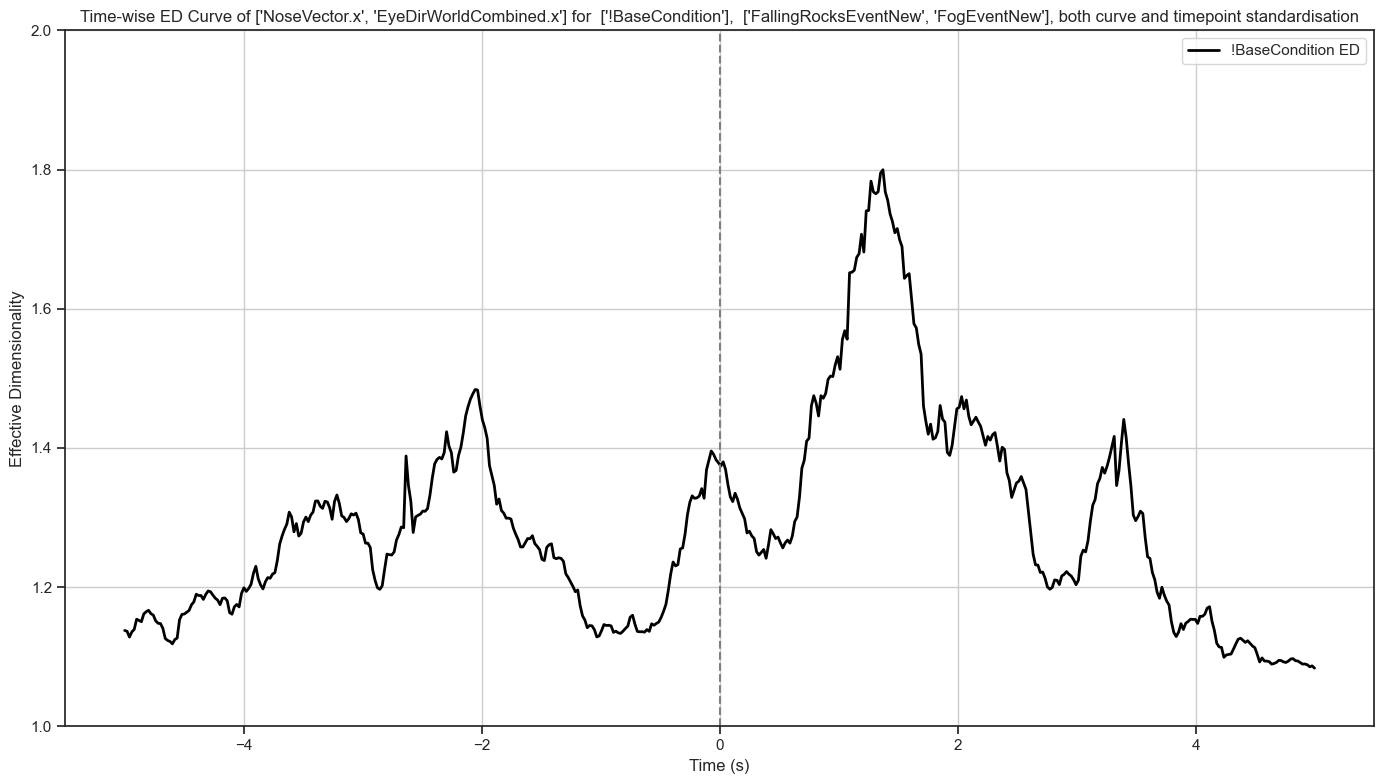

PCA based global scalar ED: 1.14 using 2 components


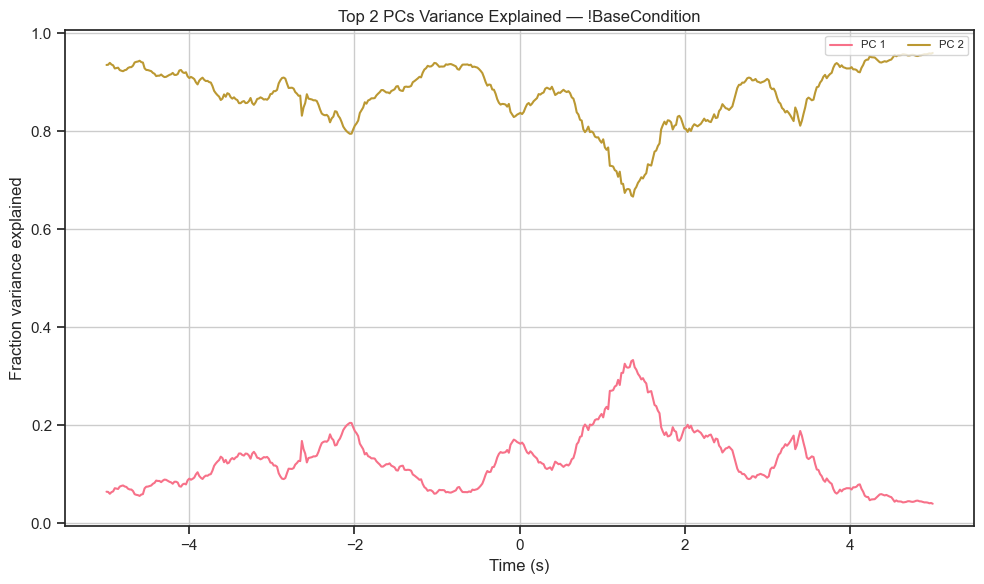

In [186]:

# Start plotting to avoid overwriting
plt.figure(figsize=(14, 8))

for condition_filter in condition_filters:
    if condition_filter == 'BaseCondition':
        cond_df = windows_event_filtered[windows_event_filtered['ExperimentalCondition']=='BaseCondition']
    else:
        cond_df = windows_event_filtered[windows_event_filtered['ExperimentalCondition']!='BaseCondition']
    # collect per‐participant curves, centered+standardized
    all_participant_curves = []
    for (_, _), sub in cond_df.groupby(['uid','WindowNumber']):
        if len(sub)!=points_per_window: continue
        data = sub[modalities].copy()
        # # center each curve on its own mean
        # for i in range(data.shape[1]):
        #     col = data.columns[i]
        #     data[col] -= data[col].mean()
        # # standardize across time
        data_scaled = StandardScaler().fit_transform(data)
        all_participant_curves.append(data_scaled.T)
    if not all_participant_curves: continue


    
    # stack into (W, T, M)
    Pca_data_array = np.stack(all_participant_curves, axis=0)          # (W, M, T)
    Pca_data_array = np.transpose(Pca_data_array, (0,2,1))             # (W, T, M)
    W,T,M = Pca_data_array.shape

    # compute covariance at each t
    cov_matrix = np.zeros((T,M,M))
    for t in range(T):
        snap = Pca_data_array[:,t,:]                                  # (W,M)
        snap -= snap.mean(axis=0)
        snap /= snap.std(axis=0, ddof=1)             # divide by std-dev per modality

        cov_matrix[t] = snap.T @ snap / (W-1)

    # ED curve
    ed = []
    for t in range(T):
        eig = eigh(cov_matrix[t], eigvals_only=True)
        p = eig/np.sum(eig)
        ed.append(1/np.sum(p**2))
    smoothed = gaussian_filter1d(ed, sigma=global_sigma)

    # plot
    secs = np.linspace(-5,5,T)
    plt.plot(secs, smoothed, label=f'{condition_filter} ED', color=colors[condition_filter], linewidth=2)

plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Effective Dimensionality")
plt.ylim(1, M)
plt.title(f"Time-wise ED Curve of {modalities} for  {condition_filters},  {event_filter_list}, both curve and timepoint standardisation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# global scalar ED
eig0 = eigh(cov_matrix[0], eigvals_only=True)
eig0 = np.clip(eig0,1e-12,None)
p0 = eig0/np.sum(eig0)
ED_global = 1/np.sum(p0**2)
print(f"PCA based global scalar ED: {ED_global:.2f} using {len(eig0)} components")













# --- Variance explained per component over time ---
eigvals_time = np.zeros((T, M))
for t in range(T):
    vals = eigh(cov_matrix[t], eigvals_only=True)
    eigvals_time[t] = np.clip(vals, 1e-12, None)
frac_var = eigvals_time / eigvals_time.sum(axis=1, keepdims=True)

# plot top K components
K = min(6, M)
plt.figure(figsize=(10, 6))
secs = np.linspace(-5, 5, T)
for i in range(K):
    plt.plot(secs, frac_var[:, i], label=f"PC {i+1}")
plt.xlabel("Time (s)")
plt.ylabel("Fraction variance explained")
plt.title(f"Top {K} PCs Variance Explained — {condition_filter}")
plt.legend(loc="upper right", ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [187]:
pwd

'c:\\Users\\erene\\OneDrive\\Desktop'

Both Individual and Group Normalization

High ED: Purely in the residual, shape‐only fluctuations, participants exhibit multiple independent coupling patterns between modalities at time t.

Low ED: Residual shape deviations across modalities collapse to a single shared pattern; after removing both scale and offset, only one correlation mode remains.

In [188]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from IPython.display import HTML

# #Assume Pca_data_array.shape == (W, T, M) and secs is defined as:
# W, T, M = Pca_data_array.shape
# secs = np.linspace(-5, 5, T)

# dim_x, dim_y = 0, 1  # indices of the two modalities (or PCs) to plot

# # compute axis limits
# all_pts = Pca_data_array[:, :, [dim_x, dim_y]].reshape(-1, 2)
# xmin, xmax = all_pts[:, 0].min(), all_pts[:, 0].max()
# ymin, ymax = all_pts[:, 1].min(), all_pts[:, 1].max()

# fig, ax = plt.subplots(figsize=(6, 6))
# scat = ax.scatter([], [], s=20, alpha=0.6)
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# ax.set_xlabel(f"Dimension {dim_x}")
# ax.set_ylabel(f"Dimension {dim_y}")

# title = ax.text(0.5, 1.05, "", transform=ax.transAxes, ha="center")

# def init():
#     scat.set_offsets([])
#     title.set_text("")
#     return scat, title

# def update(frame):
#     pts = Pca_data_array[:, frame, [dim_x, dim_y]]  # shape (W, 2)
#     scat.set_offsets(pts)
#     title.set_text(f"Time = {secs[frame]:.2f}s")
#     return scat, title

# ani = animation.FuncAnimation(
#     fig, update, frames=T, init_func=init,
#     blit=True, interval=50
# )

# HTML(ani.to_jshtml())
